# Full Statistical Equilibrium

2020.6.26    Kouui

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../")

from src.Structure import AtomCls, AtmosphereCls
from src.Atomic import Collision, PhotoIonize
from src.Atomic import LTELib, SEsolver, BasicP
from src.RadiativeTransfer import Profile
from src.Math import Integrate
from src import Constants as Cst

from src.Visual import Grotrian

In [3]:
from scipy.interpolate import interp1d

---

In [4]:
folder = "../data/atom/Ca_II/"
file     = folder + "Ca_II.Level"
file_Aji = folder + "Einstein_A/Nist.Aji"
file_CEe = folder + "Collisional_Excitation/RH.Electron"
file_CIe = folder + "Collisional_Ionization/RH.Electron"
file_PI  = folder + "Photoionization/RH.Alpha"
file_Rad = folder + "Ca_II.RadiativeLine"
atom = AtomCls.Atom(file, _file_Aji=file_Aji, _file_CEe=file_CEe)
atom.read_CI(_path_electron=file_CIe)
atom.read_PI(_path_alpha=file_PI)
atom.read_Mesh(_path=file_Rad)
atom.make_Mesh()
atom.read_Radiative_Line_intensity(_folder="../data/intensity/Ca_II/")

Reading Einstein Aji coefficient from : 
 ../data/atom/Ca_II/Einstein_A/Nist.Aji
...
Finished.

Reading Electron impact Effective Collisional Strength from : 
 ../data/atom/Ca_II/Collisional_Excitation/RH.Electron
...
Finished.

Reading Electron impact Collisional Ionization coefficient from : 
 ../data/atom/Ca_II/Collisional_Ionization/RH.Electron
...
Finished.

Reading Photoionization cross section from : 
 ../data/atom/Ca_II/Photoionization/RH.Alpha
...
Finished.

Reading wavelength mesh information from : 
 ../data/atom/Ca_II/Ca_II.RadiativeLine
...
line mesh prepared.
continuum mesh prepared.


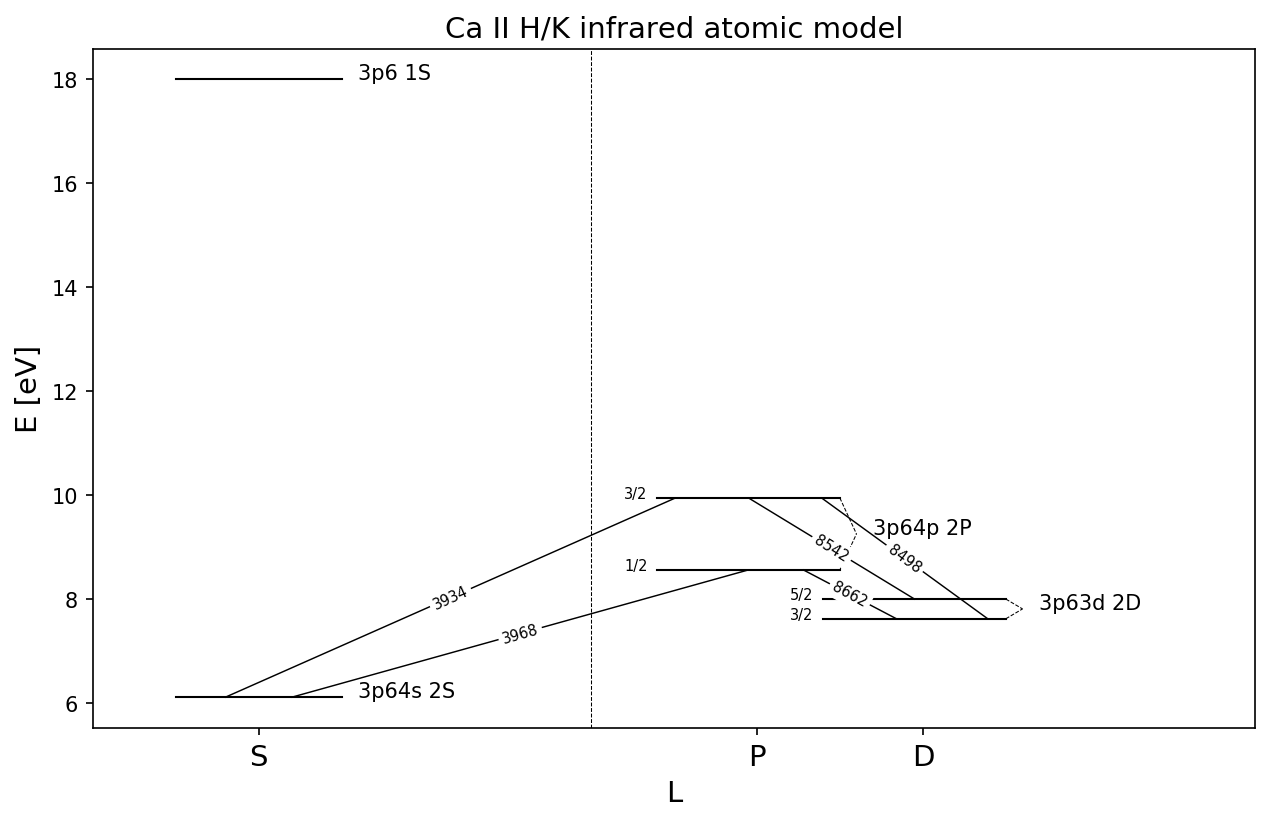

In [5]:
gro = Grotrian.Grotrian(_atom=atom, _conf_prefix="1s2.2s2.2p6.3s2.")
gro.make_fig(_figsize=(10,6),_dpi=150, _f=50)

line_plot = (
        (0, 3, "3968", 0.7, 0.5),
        (0, 4, "3934", 0.3, 0.1),
        (1, 3, "8662", 0.4, 0.8),
        (1, 4, "8498", 0.9, 0.9),
        (2, 4, "8542", 0.5, 0.5),
    )
for i, j, wl, _r1, _r2 in line_plot:
    _ctj1 = atom.Level_info_table[i]
    _ctj2 = atom.Level_info_table[j]
    gro.connect_line(_cfj1=_ctj1, _cfj2=_ctj2, _r1=_r1, _r2=_r2, _c="black", _text=wl, _tsize=7, _r=0.4)
gro.show_fig()

---

In [6]:
slab0d = AtmosphereCls.AtmosphereC0d(Te=1E4, Vt=5.E5, Ne=1E10, Vd=0E5)
slab0d.readBackgroundIntensity('../data/intensity/continuum/ASTM_E490+PROM7_HI_CaII.dat')

---

In [7]:
#--- 
# interpolate 
# - continuum intensity 
# - photoionization cross section 
# to compute photoionization rate
#
# assume : this intensity profile will not be affected by Doppler shift
#---
PI_intensity_mesh_list = PhotoIonize.interpolate_PI_intensity(_backRad=slab0d.BackRad[:,:], 
                                                           _continuum_mesh_list=atom.continuum_mesh_list)
PI_alpha_mesh_list = PhotoIonize.interpolate_PI_alpha(_PI_table_list=atom.PI_table_list, 
                                                   _continuum_mesh_list=atom.continuum_mesh_list)

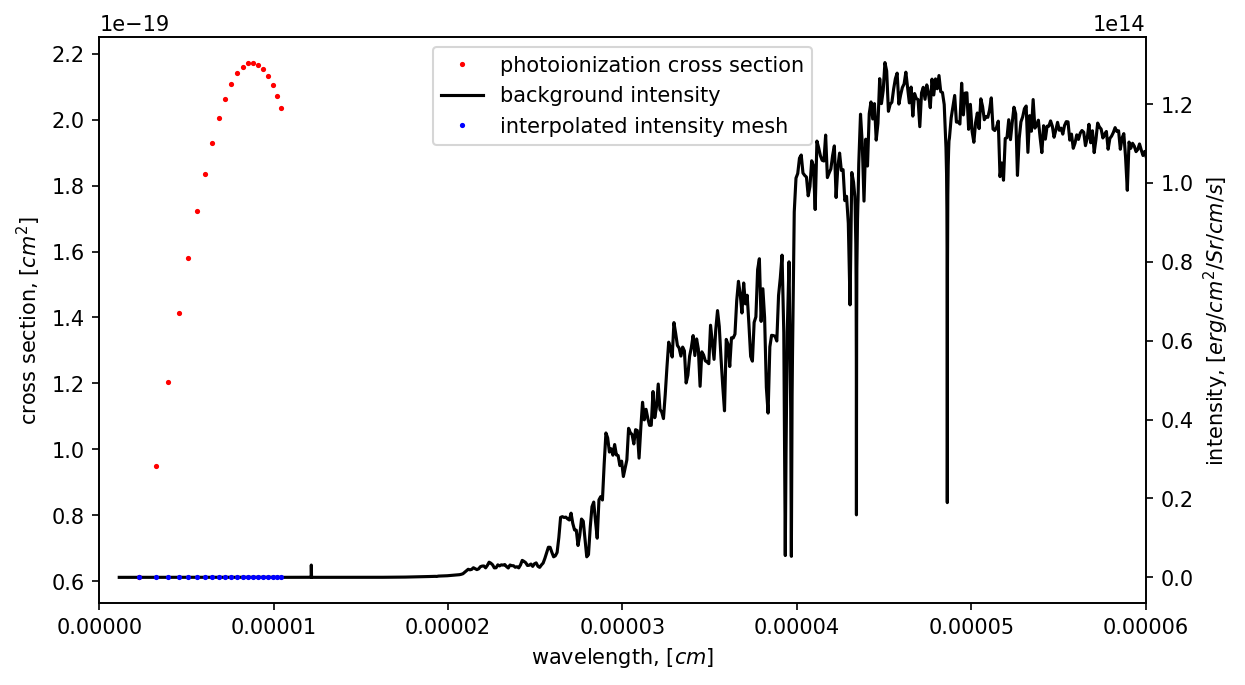

In [9]:
fig, ax1 = plt.subplots(1,1,figsize=(9,5),dpi=150)
k = 0
ax1.plot(atom.continuum_mesh_list[k][:],PI_alpha_mesh_list[k][:],
         "r.", label="photoionization cross section", markersize=3)



ax2 = ax1.twinx()
ax2.plot(slab0d.BackRad[0,:], slab0d.BackRad[1,:], "k-", 
         label="background intensity", markersize=1)

ax2.plot(atom.continuum_mesh_list[k][:], PI_intensity_mesh_list[k][:], 
         "b.", label="interpolated intensity mesh", markersize=3)

ax2.set_xlim(0,6E-5)

ax2.set_ylabel("intensity, [$erg/cm^2/Sr/cm/s$]")
ax1.set_xlabel("wavelength, [$cm$]")
ax1.set_ylabel("cross section, [$cm^{2}$]")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper center');

In [10]:
#--- 
# physical parameters
#---
_atom = atom
_Te = slab0d.data.Te
_Ne = slab0d.data.Ne
_Vt = slab0d.data.Vt
_Vd = slab0d.data.Vd
#_Vd = 100E5 # 100 [km/s]

In [11]:
#--- 
# compute LTE population ratio for each CE transition
#---

_n_LTE = LTELib.get_LTE_ratio(_erg=_atom.Level.erg[:], _g=_atom.Level.g[:],
                              _stage=_atom.Level.stage[:], _Te=_Te, _Ne=_Ne)

#--- 
# we are going to use LTE population ratio to convert C_{ij} to C_{ji},
# so we need the the LTE population of the lower/upper level of each transition
#---
_nTran = _atom.nLine
_ni_LTE = np.empty(_nTran, dtype=np.double)
_nj_LTE = np.empty(_nTran, dtype=np.double)

for k in range(_nTran):
    _ni_LTE[k] = _n_LTE[_atom.CE_coe.idxI[k]]
    _nj_LTE[k] = _n_LTE[_atom.CE_coe.idxJ[k]]

In [12]:
#--- 
# compute bound-free radiative transition rate coefficient
#    - photoionization
#    - spotaneous radiative recombination
#    - stimulated radiative recombination
#---
_Rik = np.zeros(_atom.Line.AJI.shape,dtype=np.double)
_Rki_stim = np.zeros(_atom.Line.AJI.shape,dtype=np.double)
_Rki_spon = np.zeros(_atom.Line.AJI.shape,dtype=np.double)

for k in range(_atom.nCont):
    _line_index = _atom.PI_coe.lineIndex[k]
    _res = PhotoIonize.bound_free_radiative_transition_coefficient(
                        wave = _atom.continuum_mesh_list[k][::-1],
                        J = PI_intensity_mesh_list[k][::-1] * 0.5,
                        alpha = PI_alpha_mesh_list[k][::-1],
                        Te = _Te,
                        ni_lte = _ni_LTE[_line_index],
                        nk_lte = _nj_LTE[_line_index],)
    _Rik[_line_index] = _res[0]
    _Rki_stim[_line_index] = _res[1]
    _Rki_spon[_line_index] = _res[2]

In [13]:
#--- 
# compute bound-bound radiative transition rate coefficient
#    - spotaneous radiative excitation
#    - stimulated radiative de-excitation
#---
# compute Level gamma
BasicP.get_Level_gamma(Aji=_atom.Line.AJI[:],idxJ=_atom.Line.idxJ[:],
                       gamma=_atom.Level.gamma[:])
# compute Line Gamma
BasicP.get_Line_Gamma(idxI=_atom.Line.idxI[:], idxJ=_atom.Line.idxJ[:],
                    gamma=_atom.Level.gamma[:], Gamma=_atom.Line.Gamma[:],
                    isCont=_atom.Line.isContinuum[:])
# compute 
#   - Doppler width [cm] 
#   - damping constant a [-]
#   - wavelength mesh [cm] (Doppler shifted)
#   - sbsorption profile [cm^{-1}]
# for radiative line transitions
_dopWidth_cm = np.zeros(_atom.nRadiativeLine, np.double)
_a = np.zeros(_atom.nRadiativeLine, np.double)
_Bij_Jbar = np.zeros(_atom.nLine, np.double)
_Bji_Jbar = np.zeros(_atom.nLine, np.double)
for k in range(_atom.nRadiativeLine):
    _line_index = _atom.RadLine_coe.lineIndex[k]
    _w0 = _atom.Line.w0[ _line_index ]
    _f0 = _atom.Line.f0[ _line_index ]
    _dopWidth_cm[k] = BasicP.get_Doppler_width(p0=_w0, Te=_Te, Vt=_Vt, am=_atom.am)
    _a[k] = BasicP.get_damping_a(_Gamma=_atom.Line.Gamma[_line_index], 
                                 _dopWidth_hz=_dopWidth_cm[k]*_f0/_w0 )

    _wave_mesh = _atom.line_mesh_list[k][:]
    _wave_mesh_shifted = _wave_mesh - (_w0*_Vd/Cst.c_)/_dopWidth_cm[k]
    _wave_mesh_cm = _wave_mesh_shifted[:] * _dopWidth_cm[k]
    _absorb_mesh_cm = Profile.Voigt(_a[k], _wave_mesh[:]) / _dopWidth_cm[k]
    #print(Integrate.Trapze(_absorb_mesh_cm[:], _wave_mesh_cm))
    
    _radLine = _atom.radiative_line_intensity_cm_list[k]
    _fill_value = (_radLine[1,0],_radLine[1,-1])
    _f = interp1d(x=_radLine[0,:], y=_radLine[1,:],
                  bounds_error=False, fill_value=_fill_value)
    _intensity_mesh_cm = _f(_wave_mesh_cm)
    
    _gi = _atom.Level.g[ _atom.Line.idxI[_line_index] ]
    _gj = _atom.Level.g[ _atom.Line.idxJ[_line_index] ]
    _Aji = _atom.Line.AJI[_line_index]
    _Bji, _Bij = LTELib.EinsteinA_to_EinsteinBs_cm(_Aji, _w0, _gi, _gj)
    
    _integrand = 0.5 *_intensity_mesh_cm[:] * _absorb_mesh_cm
    _Jbar = Integrate.Trapze(integrand=_integrand, x=_wave_mesh_cm)
    
    _Bji_Jbar[_line_index] = _Bji * _Jbar
    _Bij_Jbar[_line_index] = _Bij * _Jbar
    

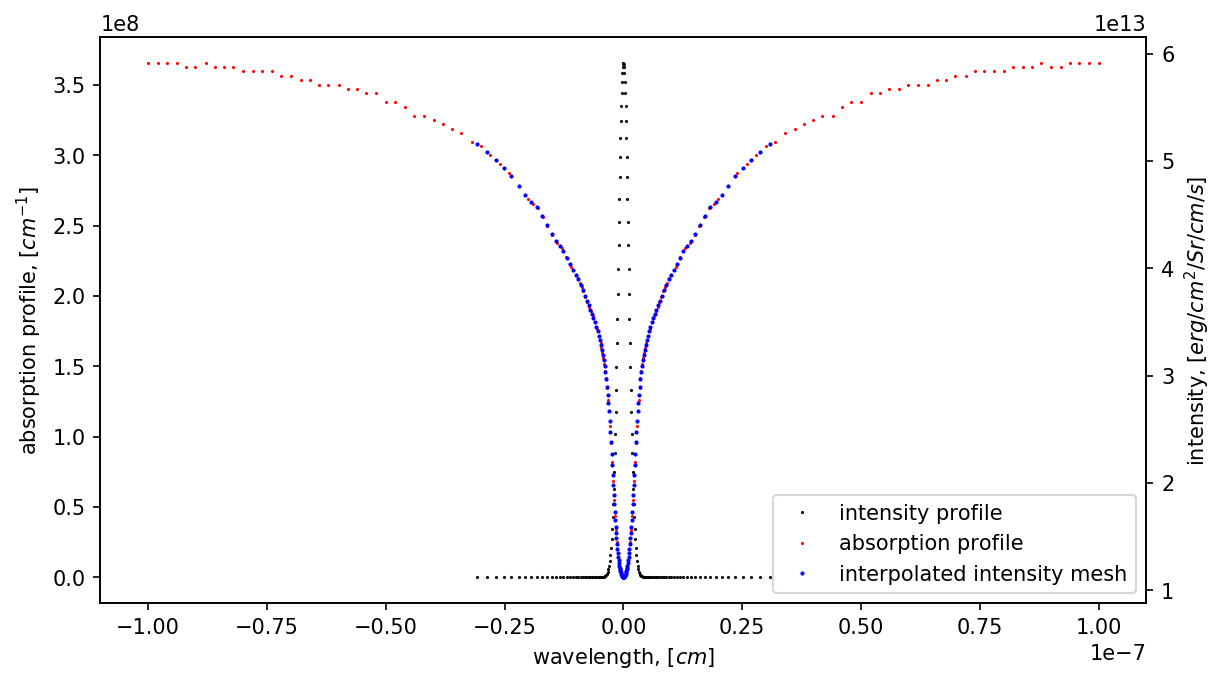

In [14]:
fig, ax1 = plt.subplots(1,1,figsize=(9,5),dpi=150)
ax1.plot(_wave_mesh_cm, _absorb_mesh_cm, "k.", 
         label="intensity profile", markersize=1)


ax2 = ax1.twinx()
ax2.plot(_radLine[0,:],_radLine[1,:],
         "r.", label="absorption profile", markersize=1)
ax2.plot(_wave_mesh_cm, _intensity_mesh_cm, "b.", 
         label="interpolated intensity mesh", markersize=2)

ax2.set_ylabel("intensity, [$erg/cm^2/Sr/cm/s$]")
ax1.set_xlabel("wavelength, [$cm$]")
ax1.set_ylabel("absorption profile, [$cm^{-1}$]")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower right');

In [15]:
#--- 
# compute collision 
#    - excitation/de-excitation 
#    - ionization/recombination
# rate coefficient
#---
_CE_fac = Collision.interpolate_CE_fac(
            _table=_atom.CE_table[:,:], _Te=_Te, 
            _Te_table=_atom.CE_Te_table[:], 
            _f1=_atom.CE_coe.f1[:], _f2=_atom.CE_coe.f2[:],
            _isCont=_atom.Line.isContinuum[:])
    
_CEij = Collision.get_CE_rate_coe(_CE_fac=_CE_fac, _Te=_Te, 
                                  _gi=_atom.CE_coe.gi[:],
                                  _dEij=_atom.CE_coe.dEij[:])

_CI_fac = Collision.interpolate_CI_fac(_table=_atom.CI_table[:,:], _Te=_Te, 
                                       _Te_table=_atom.CI_Te_table[:], 
                                       _f2=_atom.CI_coe.f2[:], 
                                       _lineIndex=_atom.CI_coe.lineIndex[:], 
                                       _nTran=_atom.nLine)
_CIij = Collision.get_CI_rate_coe(_CI_fac=_CI_fac[:], _Te=_Te, 
                                  _dEik=_atom.CE_coe.dEij[:])

_Cij = _CEij[:] + _CIij[:]
_Cji = Collision.Cij_to_Cji(_Cij=_Cij,  _ni_LTE=_ni_LTE, _nj_LTE=_nj_LTE)

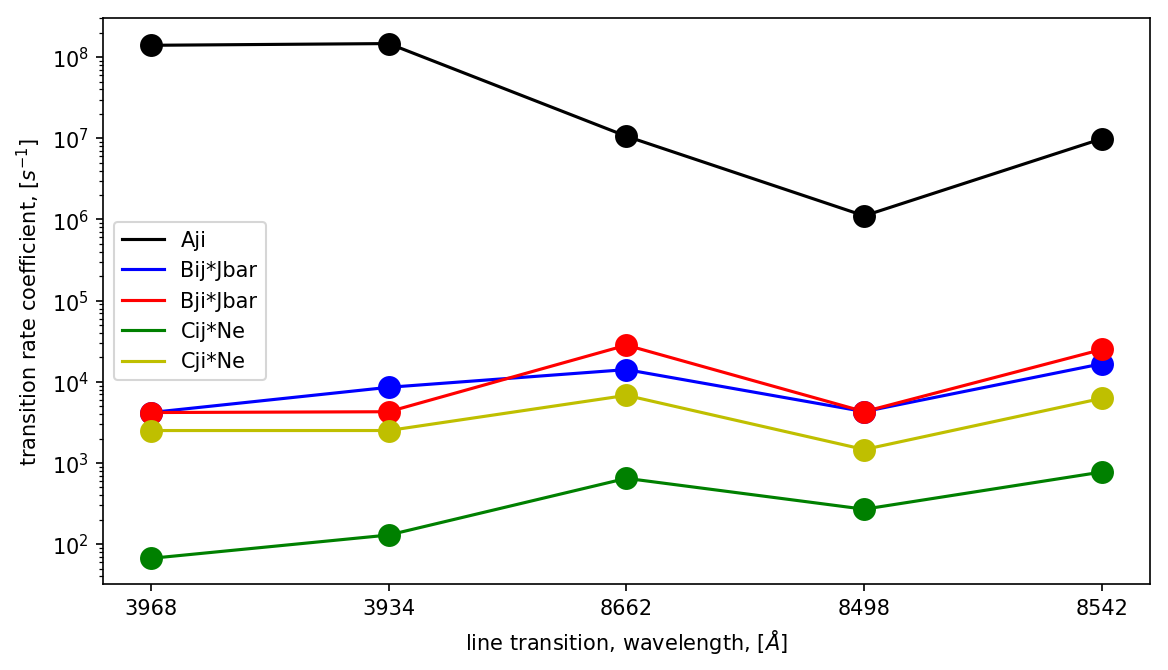

In [16]:
fig, ax = plt.subplots(1,1,figsize=(9,5),dpi=150)
mask = []
for k in range(_atom.nRadiativeLine):
    mask.append( _atom.RadLine_coe.lineIndex[k] )

ax.plot(_atom.Line.AJI[mask], "k-", label="Aji")
ax.plot(_Bij_Jbar[mask], "b-", label="Bij*Jbar")
ax.plot(_Bji_Jbar[mask], "r-", label="Bji*Jbar")
ax.plot(_Cij[mask]*_Ne, "g-", label="Cij*Ne")
ax.plot(_Cji[mask]*_Ne, "y-", label="Cji*Ne")

ax.plot(_atom.Line.AJI[mask], "ko", markersize=10)
ax.plot(_Bij_Jbar[mask], "bo", markersize=10)
ax.plot(_Bji_Jbar[mask], "ro", markersize=10)
ax.plot(_Cij[mask]*_Ne, "go", markersize=10)
ax.plot(_Cji[mask]*_Ne, "yo", markersize=10)

ax.set_ylabel("transition rate coefficient, [$s^{-1}$]")
ax.set_xlabel("line transition, wavelength, [$\AA$]")

ax.set_xticks(np.arange(_atom.nRadiativeLine))
ax.set_xticklabels([f"{_w0_AA:.0f}" for _w0_AA in _atom.Line.w0_AA[mask]])
ax.set_yscale("log")
ax.legend(loc="best")

In [17]:
#--- 
# set MatrixC (collisional)
#---
_nLevel = _atom.nLevel
_Cmat = np.zeros((_nLevel, _nLevel), dtype=np.double)
SEsolver.setMatrixC(_Cmat=_Cmat[:,:], 
                    _Cji=_Cji[:], 
                    _Cij=_Cij[:],
                    _idxI=_atom.CE_coe.idxI[:], 
                    _idxJ=_atom.CE_coe.idxJ[:], _Ne=_Ne)

#--- 
# set MatrixR (radiative)
#---
_Rmat     = np.zeros((_nLevel, _nLevel), dtype=np.double)
SEsolver.setMatrixR(_Rmat=_Rmat[:,:], 
                    _Rji_spon=_atom.Line.AJI[:]+_Rki_spon[:],
                    _Rji_stim=_Bji_Jbar[:]+_Rki_stim[:], 
                    _Rij=_Bij_Jbar[:]+_Rik[:], 
                    _idxI=_atom.Line.idxI[:], 
                    _idxJ=_atom.Line.idxJ[:])
#--- 
# solve statistical equilibrium equations
#---
_n_SE = SEsolver.solveSE(_Rmat=_Rmat[:,:], _Cmat=_Cmat[:,:])

---